# Imports

In [8]:
# CapyMoa
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from capymoa.base import  Classifier
from capymoa.classifier import HoeffdingTree, SGDClassifier
from capymoa.evaluation.visualization import plot_windowed_results

# Miscellaneous for tracking
import random
import math
import numpy as np
from collections import Counter

# CapyMOA

In [4]:
# Generates a random sample from a Poisson distribution with a given mean parameter `lambd`
def poisson(lambd, random_generator):
    if lambd < 100.0:
        product = 1.0
        _sum = 1.0
        threshold = random_generator.random() * math.exp(lambd)
        i = 1
        max_val = max(100, 10 * math.ceil(lambd))
        while i < max_val and _sum <= threshold:
            product *= lambd / i
            _sum += product
            i += 1
        return i - 1
    x = lambd + math.sqrt(lambd) * random_generator.gauss(0, 1)
    if x < 0.0:
        return 0
    return int(math.floor(x))


# Online Bagging Implementation
class CustomOnlineBagging(Classifier):
    def __init__(
        self, schema=None, random_seed=1, ensemble_size=5, base_learner_class=None
    ):
        super().__init__(schema=schema, random_seed=random_seed)

        self.random_generator = random.Random()

        self.ensemble_size = ensemble_size
        self.base_learner_class = base_learner_class

        if self.base_learner_class is None:
            self.base_learner_class = HoeffdingTree

        self.ensemble = []
        for i in range(self.ensemble_size):
            self.ensemble.append(self.base_learner_class(schema=self.schema))

    def __str__(self):
        return "CustomOnlineBagging"

    def train(self, instance):
        for i in range(self.ensemble_size):
            k = poisson(1.0, self.random_generator)
            for _ in range(k):
                self.ensemble[i].train(instance)

    def predict(self, instance):
        predictions = []
        for i in range(self.ensemble_size):
            predictions.append(self.ensemble[i].predict(instance))
        majority_vote = Counter(predictions)
        prediction = majority_vote.most_common(1)[0][0]
        return prediction

    def predict_proba(self, instance):
        probabilities = []
        for i in range(self.ensemble_size):
            classifier_proba = self.ensemble[i].predict_proba(instance)
            classifier_proba = classifier_proba / np.sum(classifier_proba)
            probabilities.append(classifier_proba)
        avg_proba = np.mean(probabilities, axis=0)
        return avg_proba

CustomOnlineBagging(HT) accuracy: 82.84781073446328, wallclock: 8.275701999664307
CustomOnlineBagging(SGD) accuracy: 81.84586864406779, wallclock: 8.428375005722046


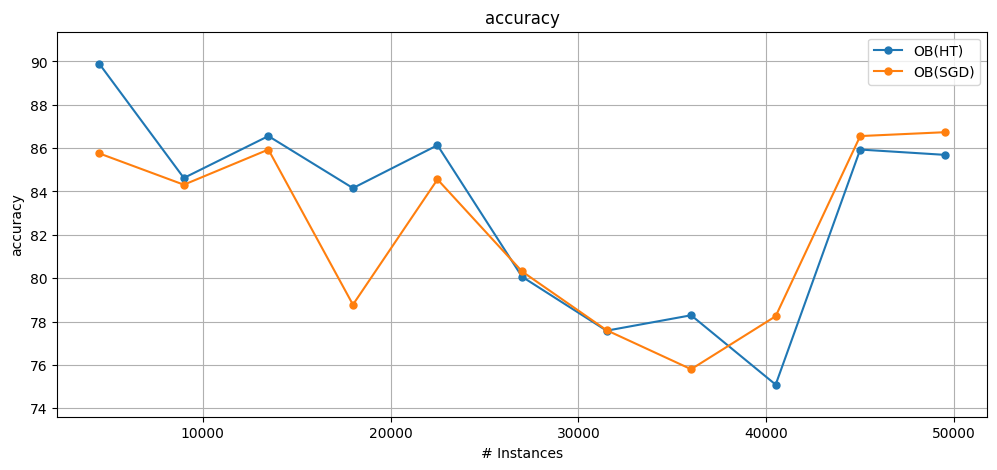

In [7]:
elec_stream = Electricity()

# Creating a learner: using a hoeffding adaptive tree as the base learner
ob_ht = CustomOnlineBagging(
    schema=elec_stream.get_schema(), ensemble_size=5, base_learner_class=HoeffdingTree
)
ob_sgd = CustomOnlineBagging(
    schema=elec_stream.get_schema(), ensemble_size=5, base_learner_class=SGDClassifier
)

results_ob_ht = prequential_evaluation(
    stream=elec_stream, learner=ob_ht, window_size=4500
)
print(
    f"CustomOnlineBagging(HT) accuracy: {results_ob_ht.cumulative.accuracy()}, wallclock: {results_ob_ht.wallclock()}"
)
results_ob_sgd = prequential_evaluation(
    stream=elec_stream, learner=ob_ht, window_size=4500
)
print(
    f"CustomOnlineBagging(SGD) accuracy: {results_ob_sgd.cumulative.accuracy()}, wallclock: {results_ob_sgd.wallclock()}"
)

results_ob_ht.learner = "OB(HT)"
results_ob_sgd.learner = "OB(SGD)"
plot_windowed_results(results_ob_ht, results_ob_sgd, metric="accuracy")